# Step 5.
#### SVM-based detection of adversarial examples
Train and evaluate SVM on binary task: benign vs adversarial embeddings to determine whether adversarial embeddings can be detected.

#### For each model, for each task
* Get clean and adversarial embeddings
* Define SVM classifier
* Train and evaluate SVM classifier

**attackPipeline (attackHyb) Env**

In [1]:
# Libraries
import json
import pickle
import numpy as np
import os
import pandas as pd

In [2]:
def get_embeddings(
    embeddings_path: str,
    split: str,
    n_folds: int = None
):
    """ Return the embeddings for the given embeddings path.
    
    Parameters
    ------------------------
    embeddings_path: str
        The embeddings path
    split: str
        The kind of split used (TVT, folds)
    n_folds: int = None
        The number of folds if split="folds" (optional)
        
    Returns
    ------------------------
    embeddings: dict[list[np.ndarray[np.float32]]. Array shape: (embedding_dim,)
        The dict with the embeddings organized per splits."""

    if split == "TVT":
        embeddings = {}
        embeddings["test"] = []
        
        embeddings_files_path = f"{embeddings_path}/test"
        for file in sorted(os.listdir(embeddings_files_path)):
            if file.endswith(".npy"):
                embedding_path = os.path.join(embeddings_files_path, file)
                embedding = np.load(embedding_path)
                embeddings["test"].append(embedding)

        print(f"stored test embeddings {embeddings_files_path}")

        return embeddings

    elif split == "folds":
        embeddings = {}
        
        for fold in range(n_folds):
            embeddings[f"fold0{fold}"] = []
            
            embeddings_files_path = f"{embeddings_path}/fold0{fold}"
            for file in sorted(os.listdir(embeddings_files_path)):
                if file.endswith(".npy"):
                    embedding_path = os.path.join(embeddings_files_path, file)
                    embedding = np.load(embedding_path)
                    embeddings[f"fold0{fold}"].append(embedding)
                    
            print(f"stored in fold0{fold} embeddings {embeddings_files_path}")

        return embeddings

In [3]:
# Pickle load embeddings and adversarial embeddings

# Get task names
with open('datasets.json', 'r') as file:
    datasets = json.load(file)
tasks_name = []
for task in datasets:
    tasks_name.append(task["name"])

models_name = ["efficient_latent", "GURA.fusion_hubert_xlarge", "GURA.fusion_wav2vec2", "GURA.fusion_cat_xwc", "GURA.avg_xwc", "hear21passt.base", "hearbaseline.wav2vec2", "audio_dbert", "panns_hear"]
attack_types = ["Boundary", "HopSkipJump"]

clean_embeddings = {}
adversarial_embeddings = {}

# Load Dataset (Read dictionary pkl file)
for model_name in models_name:
    clean_embeddings[model_name] = {}
    adversarial_embeddings[model_name] = {}

    for task_name in tasks_name:
        clean_embeddings[model_name][task_name] = []
        adversarial_embeddings[model_name][task_name] = {}

        # Get metadata
        embeddings_path = f"embeddings/{model_name}/{task_name}"
        metadata_path = f"{embeddings_path}/task_metadata.json"

        with open(metadata_path, 'r') as file:
            metadata = json.load(file)

        if metadata["split_mode"] == "new_split_kfold" or metadata["split_mode"] == "presplit_kfold":
            split = "folds"
            n_folds = metadata["nfolds"]
        elif metadata["split_mode"] == "trainvaltest":
            split = "TVT"
            n_folds = None

        # Get clean embeddings
        embeddings = get_embeddings(embeddings_path, split, n_folds)
        clean_embeddings[model_name][task_name].append(embeddings)

        for attack_type in attack_types:
            adversarial_embeddings[model_name][task_name][attack_type] = []

            # Get adversarial_embeddings
            with open(f'adversarial_computations/{model_name}/{task_name}/{attack_type}_adv_embeddings.pkl', 'rb') as fp:
                print(f"\n- {attack_type} adv embeddings -")
                adv_embeddings = pickle.load(fp)
                adversarial_embeddings[model_name][task_name][attack_type].append(adv_embeddings)

            print("")

stored in fold00 embeddings embeddings/efficient_latent/beijing_opera/fold00
stored in fold01 embeddings embeddings/efficient_latent/beijing_opera/fold01
stored in fold02 embeddings embeddings/efficient_latent/beijing_opera/fold02
stored in fold03 embeddings embeddings/efficient_latent/beijing_opera/fold03
stored in fold04 embeddings embeddings/efficient_latent/beijing_opera/fold04

- Boundary adv embeddings -


- HopSkipJump adv embeddings -

stored in fold00 embeddings embeddings/efficient_latent/esc50/fold00
stored in fold01 embeddings embeddings/efficient_latent/esc50/fold01
stored in fold02 embeddings embeddings/efficient_latent/esc50/fold02
stored in fold03 embeddings embeddings/efficient_latent/esc50/fold03
stored in fold04 embeddings embeddings/efficient_latent/esc50/fold04

- Boundary adv embeddings -


- HopSkipJump adv embeddings -

stored in fold00 embeddings embeddings/efficient_latent/gunshot/fold00
stored in fold01 embeddings embeddings/efficient_latent/gunshot/fold01
st

In [4]:
# Get input data for SVM: clean embeddings and adversarial embeddings (Boundary and HopSkipJump)
x_clean_embeddings = {}
for model in clean_embeddings:
    x_clean_embeddings[model] = {}
    for task in clean_embeddings[model]:
        x_clean_embeddings[model][task] = []
        for split in clean_embeddings[model][task][0]:
            print(f"Get Clean X: {model} - {task} - {split}")
            x_clean_embeddings[model][task].append(clean_embeddings[model][task][0][split])

x_adversarial_embeddings = {}
for model in adversarial_embeddings:
    x_adversarial_embeddings[model] = {}
    for task in adversarial_embeddings[model]:
        x_adversarial_embeddings[model][task] = {}
        for attack in adversarial_embeddings[model][task]:
            x_adversarial_embeddings[model][task][attack] = []
            for split in adversarial_embeddings[model][task][attack][0]:
                print(f"Get Adv X: {model} - {task} - {attack} - {split}")
                x_adversarial_embeddings[model][task][attack].append(adversarial_embeddings[model][task][attack][0][split])

Get Clean X: efficient_latent - beijing_opera - fold00
Get Clean X: efficient_latent - beijing_opera - fold01
Get Clean X: efficient_latent - beijing_opera - fold02
Get Clean X: efficient_latent - beijing_opera - fold03
Get Clean X: efficient_latent - beijing_opera - fold04
Get Clean X: efficient_latent - esc50 - fold00
Get Clean X: efficient_latent - esc50 - fold01
Get Clean X: efficient_latent - esc50 - fold02
Get Clean X: efficient_latent - esc50 - fold03
Get Clean X: efficient_latent - esc50 - fold04
Get Clean X: efficient_latent - gunshot - fold00
Get Clean X: efficient_latent - gunshot - fold01
Get Clean X: efficient_latent - gunshot - fold02
Get Clean X: efficient_latent - gunshot - fold03
Get Clean X: efficient_latent - gunshot - fold04
Get Clean X: efficient_latent - gunshot - fold05
Get Clean X: efficient_latent - gunshot - fold06
Get Clean X: efficient_latent - libricount - fold00
Get Clean X: efficient_latent - libricount - fold01
Get Clean X: efficient_latent - libricount 

In [5]:
# Input shape example
print(np.array(x_clean_embeddings["audio_dbert"]["esc50"], dtype='object').shape)
print(np.array(x_adversarial_embeddings["audio_dbert"]["esc50"]["Boundary"], dtype='object').shape)
print(np.array(x_adversarial_embeddings["audio_dbert"]["esc50"]["HopSkipJump"], dtype='object').shape)

(5, 400, 2048)
(5, 400, 2048)
(5, 400, 2048)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

def SVM(
    X_train: np.ndarray,
    X_test: np.ndarray,
    Y_train: np.ndarray,
    Y_test: np.ndarray
):
    """ Train an SVM on the train data portion and evaluate it on the test data portion.
    
    Parameters
    ------------------------
    X_train: np.ndarray
        Train inputs
    X_test: np.ndarray
        Test inputs
    Y_train: np.ndarray
        Train labels
    Y_test: np.ndarray
        Test labels
        
    Returns
    ------------------------
    accuracy: float
        The accuracy score over the test predictions
    f1_score: float
        The F1 score over the test predictions
    """
    
    # Initialize SVM classifier
    svm_classifier = SVC(kernel='rbf')  # rbf', 'poly', 'sigmoid'
    
    # Train the SVM classifier
    svm_classifier.fit(X_train, Y_train)
    
    # Predict for test data
    Y_pred = svm_classifier.predict(X_test)

    # Compute accuracy and F1 score metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)

    return accuracy, f1

#### Main SVM training and evaluation loop
Stores the results in *results_SVM*

In [12]:
# Notes
# The SVM is trained and evaluated 1 time for each model-task-attack combination.
# In case of a TVT split the test fold is further split into train-test (only on this set the aversarial embeddings were computed) (still large enought for an accurate evaluation).
# In case of a K-fold split the test fold is fold00 and the rest are for training (no need for k-fold CV.
#  Given the data size and the fact that each fold is balanced with respect to the classes a single test is enought).

SVM_results = {}

for model in x_clean_embeddings:
    SVM_results[model] = {}
    for task in x_clean_embeddings[model]:
        SVM_results[model][task] = {}
        for attack in ["Boundary", "HopSkipJump"]:
            SVM_results[model][task][attack] = {}
            # Get train, test data split
            # TVT Split
            if len(x_clean_embeddings[model][task]) == 1:
                X_clean = np.array(x_clean_embeddings[model][task][0])
                X_adv = np.array(x_adversarial_embeddings[model][task][attack][0])

                X = np.concatenate((X_clean, X_adv), axis=0)
                Y = np.concatenate((np.zeros(X_clean.shape[0]), np.ones(X_adv.shape[0])), axis=0)

                X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

            # K-fold split
            else:
                for n_fold in range(len(x_clean_embeddings[model][task])):
                    X_clean = np.array(x_clean_embeddings[model][task][n_fold])
                    X_adv = np.array(x_adversarial_embeddings[model][task][attack][n_fold])

                    # Test fold
                    if n_fold == 0:
                        X_test = np.concatenate((X_clean, X_adv), axis=0)
                        Y_test = np.concatenate((np.zeros(X_clean.shape[0]), np.ones(X_adv.shape[0])), axis=0)

                    # Train folds
                    elif n_fold == 1:
                        X_train = np.concatenate((X_clean, X_adv), axis=0)
                        Y_train = np.concatenate((np.zeros(X_clean.shape[0]), np.ones(X_adv.shape[0])), axis=0)
                    else:
                        X_fold = np.concatenate((X_clean, X_adv), axis=0)
                        Y_fold = np.concatenate((np.zeros(X_clean.shape[0]), np.ones(X_adv.shape[0])), axis=0)

                        X_train = np.concatenate((X_train, X_fold), axis=0)
                        Y_train = np.concatenate((Y_train, Y_fold), axis=0)

                # Shuffle the arrays
                train_indices = np.arange(len(X_train))
                test_indices = np.arange(len(X_test))

                np.random.shuffle(train_indices)
                np.random.shuffle(test_indices)

                X_train = X_train[train_indices]
                Y_train = Y_train[train_indices]
                X_test = X_test[test_indices]
                Y_test = Y_test[test_indices]

            # Train SVM and get results
            accuracy, f1 = SVM(X_train, X_test, Y_train, Y_test)

            print(f"-- Main SVM loop for {model} on task {task} over {attack} embeddings --\n-Results: Accuracy: {accuracy:.4f}, F1_Score: {f1:.4f}\n")

            SVM_results[model][task][attack]["Accuracy"] = []
            SVM_results[model][task][attack]["F1_Score"] = []

            SVM_results[model][task][attack]["Accuracy"].append(accuracy)
            SVM_results[model][task][attack]["F1_Score"].append(f1)

-- Main SVM loop for efficient_latent on task beijing_opera over Boundary embeddings --
-Results: Accuracy: 0.6354, F1_Score: 0.5070

-- Main SVM loop for efficient_latent on task beijing_opera over HopSkipJump embeddings --
-Results: Accuracy: 0.6875, F1_Score: 0.6154

-- Main SVM loop for efficient_latent on task esc50 over Boundary embeddings --
-Results: Accuracy: 0.7362, F1_Score: 0.6719

-- Main SVM loop for efficient_latent on task esc50 over HopSkipJump embeddings --
-Results: Accuracy: 0.8137, F1_Score: 0.7933

-- Main SVM loop for efficient_latent on task gunshot over Boundary embeddings --
-Results: Accuracy: 0.5417, F1_Score: 0.1538

-- Main SVM loop for efficient_latent on task gunshot over HopSkipJump embeddings --
-Results: Accuracy: 0.5000, F1_Score: 0.1429

-- Main SVM loop for efficient_latent on task libricount over Boundary embeddings --
-Results: Accuracy: 0.6726, F1_Score: 0.5402

-- Main SVM loop for efficient_latent on task libricount over HopSkipJump embeddings

In [13]:
SVM_results

{'efficient_latent': {'beijing_opera': {'Boundary': {'Accuracy': [0.6354166666666666],
    'F1_Score': [0.5070422535211269]},
   'HopSkipJump': {'Accuracy': [0.6875], 'F1_Score': [0.6153846153846154]}},
  'esc50': {'Boundary': {'Accuracy': [0.73625],
    'F1_Score': [0.671850699844479]},
   'HopSkipJump': {'Accuracy': [0.81375], 'F1_Score': [0.7933425797503467]}},
  'gunshot': {'Boundary': {'Accuracy': [0.5416666666666666],
    'F1_Score': [0.15384615384615385]},
   'HopSkipJump': {'Accuracy': [0.5], 'F1_Score': [0.14285714285714285]}},
  'libricount': {'Boundary': {'Accuracy': [0.6726398601398601],
    'F1_Score': [0.5402087170042972]},
   'HopSkipJump': {'Accuracy': [0.7473776223776224],
    'F1_Score': [0.6738148984198645]}},
  'mridangam_stroke': {'Boundary': {'Accuracy': [0.5995702005730659],
    'F1_Score': [0.40277777777777773]},
   'HopSkipJump': {'Accuracy': [0.6615329512893983],
    'F1_Score': [0.6044370029300963]}},
  'mridangam_tonic': {'Boundary': {'Accuracy': [0.55085959

In [16]:
# Pickle save SVM_results
SVM_results_path = f"results_SVM"
if not(os.path.exists(SVM_results_path)):
    os.makedirs(SVM_results_path)
with open(f'{SVM_results_path}/SVM_results.pkl', 'wb') as fp:
    pickle.dump(SVM_results, fp)
    print(f"\n- (Save) SVM metrics stored in results")


- (Save) SVM metrics stored in results


### Results

#### Per model

In [4]:
# Pickle load SVM_results
with open(f'results_SVM/SVM_results.pkl', 'rb') as fp:
    SVM_results = pickle.load(fp)

In [5]:
SVM_model_results = {}
for model in SVM_results:
    SVM_model_results[model] = {}
    for task in SVM_results[model]:
        for attack in SVM_results[model][task]:
            SVM_model_results[model][attack] = {}
            for metric in ["Accuracy", "F1_Score"]:
                SVM_model_results[model][attack][metric] = []

for model in SVM_results:
    for task in SVM_results[model]:
        for attack in SVM_results[model][task]:
            SVM_model_results[model][attack]["Accuracy"].append(SVM_results[model][task][attack]["Accuracy"])
            SVM_model_results[model][attack]["F1_Score"].append(SVM_results[model][task][attack]["F1_Score"])

In [6]:
SVM_model_results

{'efficient_latent': {'Boundary': {'Accuracy': [[0.6354166666666666],
    [0.73625],
    [0.5416666666666666],
    [0.6726398601398601],
    [0.5995702005730659],
    [0.5508595988538681],
    [0.28],
    [0.32413087934560325],
    [0.5051282051282051],
    [0.765],
    [0.5],
    [0.511760752688172]],
   'F1_Score': [[0.5070422535211269],
    [0.671850699844479],
    [0.15384615384615385],
    [0.5402087170042972],
    [0.40277777777777773],
    [0.32216216216216215],
    [0.2087912087912088],
    [0.29153269024651657],
    [0.31316725978647686],
    [0.7314285714285714],
    [0.13333333333333336],
    [0.18140845070422537]]},
  'HopSkipJump': {'Accuracy': [[0.6875],
    [0.81375],
    [0.5],
    [0.7473776223776224],
    [0.6615329512893983],
    [0.6335959885386819],
    [0.285],
    [0.3486707566462168],
    [0.5],
    [0.745],
    [0.5],
    [0.552755376344086]],
   'F1_Score': [[0.6153846153846154],
    [0.7933425797503467],
    [0.14285714285714285],
    [0.6738148984198645],
  

In [7]:
models = []
accuracy_B = []
f1_score_B = []
accuracy_H = []
f1_score_H = []

# Extract data for barplot
for model, tasks in SVM_model_results.items():
    for attack, metrics in tasks.items():
        if attack == "Boundary":
            models.extend([model] * len(metrics['Accuracy']))
            accuracy_B.extend([item for sublist in metrics['Accuracy'] for item in sublist])
            f1_score_B.extend([item for sublist in metrics['F1_Score'] for item in sublist])
        elif attack == "HopSkipJump":
            accuracy_H.extend([item for sublist in metrics['Accuracy'] for item in sublist])
            f1_score_H.extend([item for sublist in metrics['F1_Score'] for item in sublist])

# Format as DataFrame
barplot_model_DF = pd.DataFrame({
    'Model': models,
    'Boundary Accuracy': accuracy_B,
    'Boundary F1 score': f1_score_B,
    'HopSkipJump Accuracy': accuracy_H,
    'HopSkipJump F1 score': f1_score_H
})

print(barplot_model_DF)

                Model  Boundary Accuracy  Boundary F1 score  \
0    efficient_latent           0.635417           0.507042   
1    efficient_latent           0.736250           0.671851   
2    efficient_latent           0.541667           0.153846   
3    efficient_latent           0.672640           0.540209   
4    efficient_latent           0.599570           0.402778   
..                ...                ...                ...   
103        panns_hear           0.617076           0.372171   
104        panns_hear           0.553846           0.194444   
105        panns_hear           0.895000           0.882682   
106        panns_hear           0.846154           0.818182   
107        panns_hear           0.689180           0.549440   

     HopSkipJump Accuracy  HopSkipJump F1 score  
0                0.687500              0.615385  
1                0.813750              0.793343  
2                0.500000              0.142857  
3                0.747378              0.67

[(<Figure size 2400x540 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'HopSkipJump Accuracy'}, xlabel='HopSkipJump Accuracy'>],
        dtype=object)),
 (<Figure size 2400x540 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'HopSkipJump F1 Score'}, xlabel='HopSkipJump F1 Score'>],
        dtype=object)),
 (<Figure size 2400x540 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'Boundary Accuracy'}, xlabel='Boundary Accuracy'>],
        dtype=object)),
 (<Figure size 2400x540 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'Boundary F1 Score'}, xlabel='Boundary F1 Score'>],
        dtype=object))]

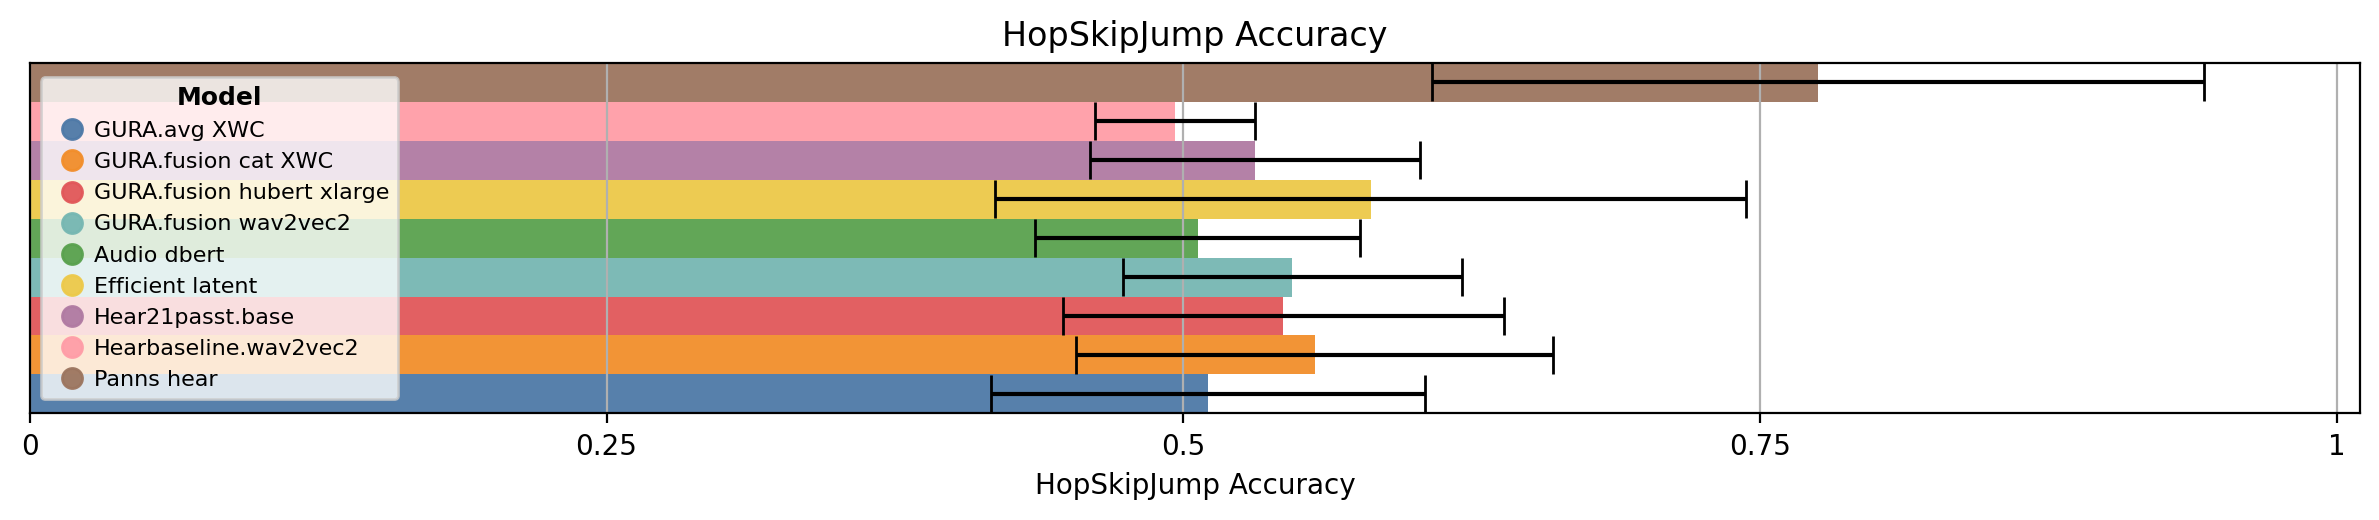

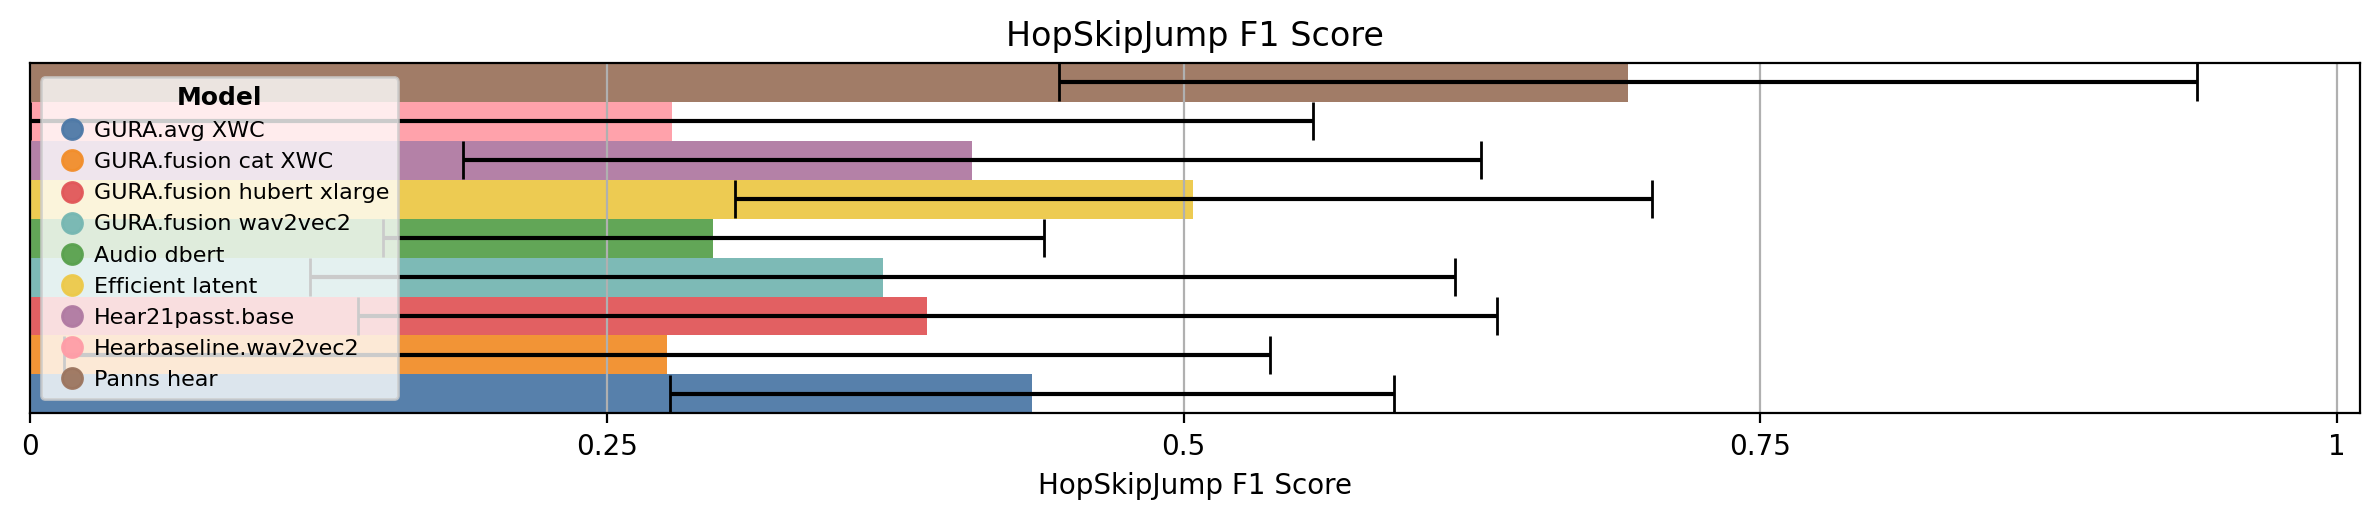

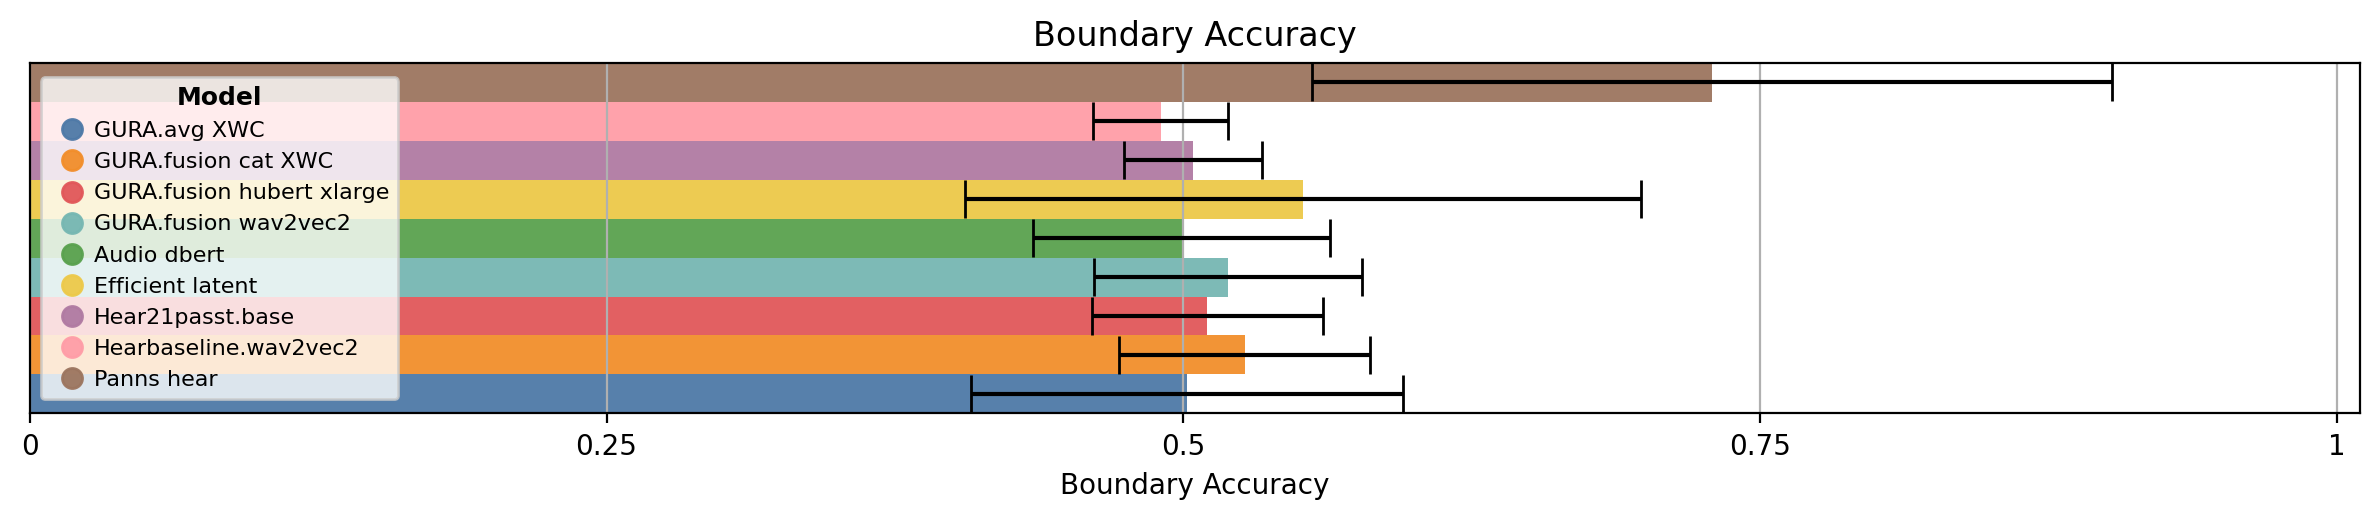

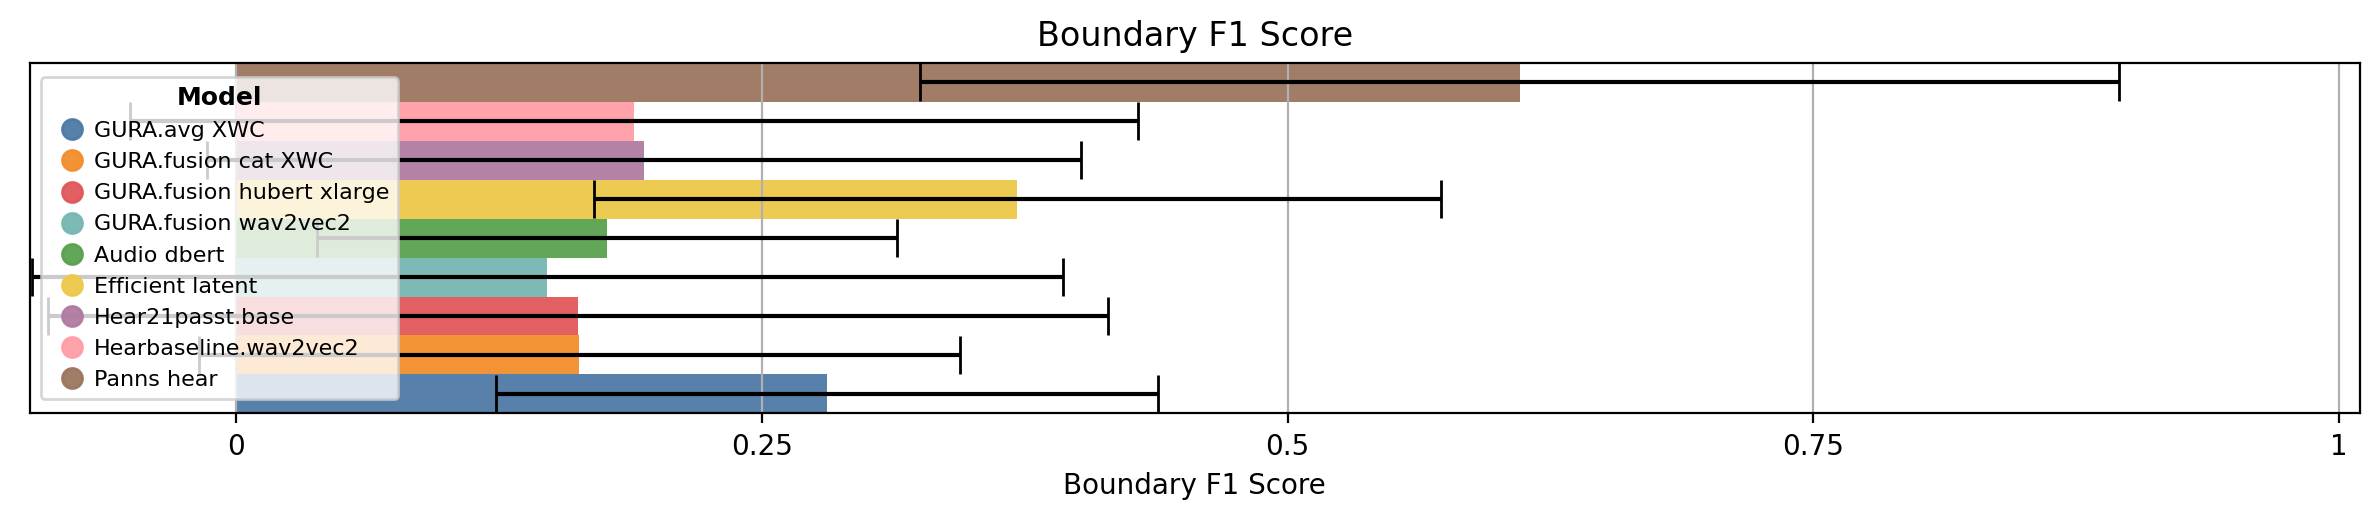

In [13]:
from barplots import barplots

barplots(
    barplot_model_DF,
    groupby=["Model"],
    orientation="horizontal",
    height=12,
    legend_position="center left"
)

### Note on embeddings

In [6]:
# In general the SVM has a hard time detecting the perturbation and dinstinghuishing clean vs adversarial embeddings
# Exception: Panns Hear model
# As shown here the Panns Hear model's embeddings have 0.0 as min and frequent value, this, which already made the model the most robust across all models,
# renders the identification of perturbation much easier.
# This further validates the fact that embeddings that are normalized/within a fixed min-max range handle better this kind of attack.

# Check of the actual clean and adversarial embeddings (first 100 values for GTZAN_music task) and prepare data for line plot
models_names = ["GURA.fusion_hubert_xlarge", "hear21passt.base", "panns_hear"]

clean_emb_plot = []
adv_emb_plot = []
for task in clean_embeddings["GURA.fusion_hubert_xlarge"]:
    if task == "GTZAN_music":
        for model_name in models_names:
            print(f"{model_name} -- {task} (clean and adversarial)")
            rounded_vector = [round(num, 4) for num in clean_embeddings[model_name][task][0]["fold00"][0][:100]]
            print(rounded_vector)
            clean_emb_plot.append(rounded_vector)
            print("-"*10)
            rounded_vector = [round(num, 4) for num in adversarial_embeddings[model_name][task]["Boundary"][0]["fold00"][0][:100]]
            print(rounded_vector)
            adv_emb_plot.append(rounded_vector)
            print("\n")

diff_embeddings = [np.array(adv) - np.array(clean) for adv, clean in zip(adv_emb_plot, clean_emb_plot)]

GURA.fusion_hubert_xlarge -- GTZAN_music (clean and adversarial)
[2.8981, 2.7632, 3.1061, 2.4418, -3.1715, 2.8071, -7.2266, -5.5504, 6.6203, 6.305, 8.4879, 0.6309, 2.1236, 5.8762, 3.9833, 7.8235, -7.3272, 1.2676, -2.3991, 5.4619, -1.5947, 10.5106, -11.598, -1.3275, 2.4358, -0.2918, 19.0911, 6.8439, 5.4706, -2.9527, -8.4999, -3.2584, 5.3603, -2.9647, -2.5484, 3.2652, 7.9609, -10.5415, -5.9285, -5.3475, 8.9046, 7.709, -6.7251, 5.4031, -1.468, 5.2737, -10.7929, 6.2505, -5.3568, 4.2033, 2.0181, 2.0837, -4.8198, 2.674, 6.0695, 4.8297, 3.4713, 1.5692, 3.2022, 0.7077, 3.5468, 2.4976, 7.2692, -1.8006, 6.5937, -3.2739, 4.3829, -8.7796, 3.71, -5.4047, -6.8278, -8.9127, 5.4442, -0.0988, 3.3715, -4.6589, -5.7393, -7.0193, 4.6782, -5.2195, 4.7572, 2.6657, 0.603, -3.0423, 9.1626, 3.1325, 2.7056, -5.0364, 2.5227, 5.5121, -0.9339, 5.1739, 8.7544, 1.3816, 5.1969, 4.245, -2.247, -0.8626, -4.8263, -16.3642]
----------
[4.277, 1.3368, 3.395, 2.2008, -3.9168, 4.0527, -6.3716, -6.9777, 7.1348, 6.6524, 7.685

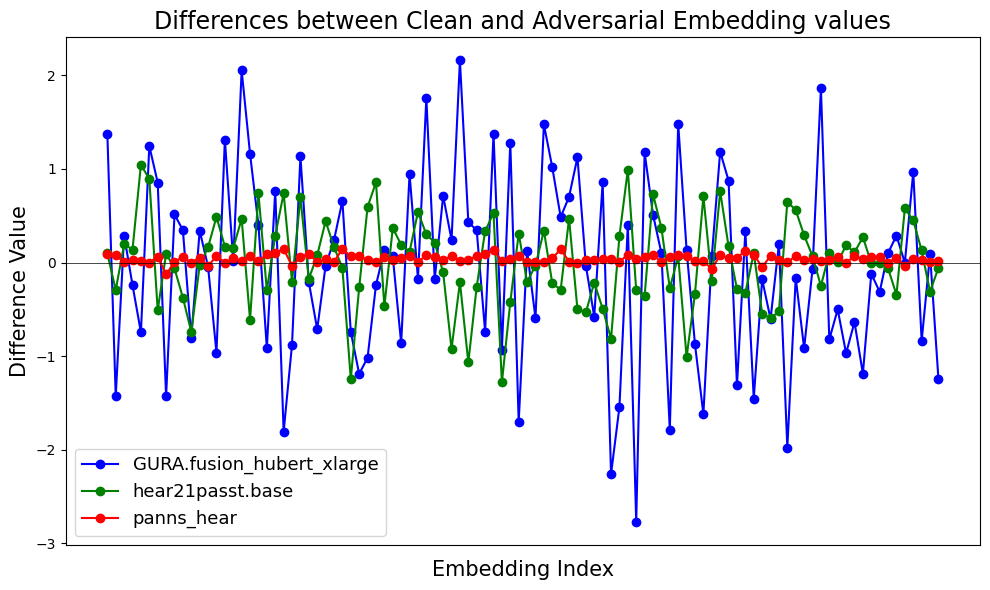

In [13]:
import matplotlib.pyplot as plt
# Plotting line plot for differences across dimensions
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue', 'green', 'red']
for i, model in enumerate(models_names):
    x = np.arange(len(clean_emb_plot[i]))
    ax.plot(x, diff_embeddings[i], label=f'{model}', marker='o', color=colors[i])

ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('Differences between Clean and Adversarial Embedding values', fontsize=17)
ax.set_xticks(x)
ax.set_xticklabels("")
ax.set_ylabel('Difference Value', fontsize=15)
ax.set_xlabel('Embedding Index', fontsize=15)
ax.legend(fontsize=13)

plt.tick_params(bottom=False)
plt.tight_layout()
plt.savefig('embLinePlot.png', format='png')
plt.show()

#### Per Task

In [9]:
# Get task names
with open('datasets.json', 'r') as file:
    datasets = json.load(file)
tasks_name = []
for task in datasets:
    tasks_name.append(task["name"])

SVM_task_results = {}
for task in tasks_name:
    SVM_task_results[task] = {} 
    for model in SVM_results:
        for attack in SVM_results[model][task]:
            SVM_task_results[task][attack] = {}
            for metric in ["Accuracy", "F1_Score"]:
                SVM_task_results[task][attack][metric] = []

for task in tasks_name:
    for model in SVM_results:
        for attack in SVM_results[model][task]:
            SVM_task_results[task][attack]["Accuracy"].append(SVM_results[model][task][attack]["Accuracy"])
            SVM_task_results[task][attack]["F1_Score"].append(SVM_results[model][task][attack]["F1_Score"])

In [10]:
SVM_task_results

{'beijing_opera': {'Boundary': {'Accuracy': [[0.6354166666666666],
    [0.5],
    [0.5],
    [0.5],
    [0.5625],
    [0.5],
    [0.5],
    [0.5104166666666666],
    [0.875]],
   'F1_Score': [[0.5070422535211269],
    [0.0],
    [0.0],
    [0.0],
    [0.2222222222222222],
    [0.039999999999999994],
    [0.0],
    [0.14545454545454545],
    [0.8571428571428571]]},
  'HopSkipJump': {'Accuracy': [[0.6875],
    [0.5104166666666666],
    [0.5208333333333334],
    [0.5],
    [0.5520833333333334],
    [0.4895833333333333],
    [0.5104166666666666],
    [0.53125],
    [0.90625]],
   'F1_Score': [[0.6153846153846154],
    [0.1754385964912281],
    [0.25806451612903225],
    [0.0],
    [0.18867924528301885],
    [0.3098591549295775],
    [0.0784313725490196],
    [0.21052631578947367],
    [0.896551724137931]]}},
 'esc50': {'Boundary': {'Accuracy': [[0.73625],
    [0.5],
    [0.5],
    [0.515],
    [0.505],
    [0.585],
    [0.5],
    [0.51125],
    [0.9125]],
   'F1_Score': [[0.671850699844479

In [11]:
tasks = []
accuracy_B = []
f1_score_B = []
accuracy_H = []
f1_score_H = []

# Extract data for barplot
for task, models in SVM_task_results.items():
    for attack, metrics in models.items():
        if attack == "Boundary":
            tasks.extend([task] * len(metrics['Accuracy']))
            accuracy_B.extend([item for sublist in metrics['Accuracy'] for item in sublist])
            f1_score_B.extend([item for sublist in metrics['F1_Score'] for item in sublist])
        elif attack == "HopSkipJump":
            accuracy_H.extend([item for sublist in metrics['Accuracy'] for item in sublist])
            f1_score_H.extend([item for sublist in metrics['F1_Score'] for item in sublist])

# Format as DataFrame
barplot_task_DF = pd.DataFrame({
    'Task': tasks,
    'Boundary Accuracy': accuracy_B,
    'Boundary F1 score': f1_score_B,
    'HopSkipJump Accuracy': accuracy_H,
    'HopSkipJump F1 score': f1_score_H
})

print(barplot_task_DF)

              Task  Boundary Accuracy  Boundary F1 score  \
0    beijing_opera           0.635417           0.507042   
1    beijing_opera           0.500000           0.000000   
2    beijing_opera           0.500000           0.000000   
3    beijing_opera           0.500000           0.000000   
4    beijing_opera           0.562500           0.222222   
..             ...                ...                ...   
103        crema-D           0.503360           0.146651   
104        crema-D           0.500000           0.004016   
105        crema-D           0.500000           0.011952   
106        crema-D           0.502016           0.056051   
107        crema-D           0.689180           0.549440   

     HopSkipJump Accuracy  HopSkipJump F1 score  
0                0.687500              0.615385  
1                0.510417              0.175439  
2                0.520833              0.258065  
3                0.500000              0.000000  
4                0.552083    

[(<Figure size 2400x720 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'HopSkipJump Accuracy'}, xlabel='HopSkipJump Accuracy'>],
        dtype=object)),
 (<Figure size 2400x720 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'HopSkipJump F1 Score'}, xlabel='HopSkipJump F1 Score'>],
        dtype=object)),
 (<Figure size 2400x720 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'Boundary Accuracy'}, xlabel='Boundary Accuracy'>],
        dtype=object)),
 (<Figure size 2400x720 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'Boundary F1 Score'}, xlabel='Boundary F1 Score'>],
        dtype=object))]

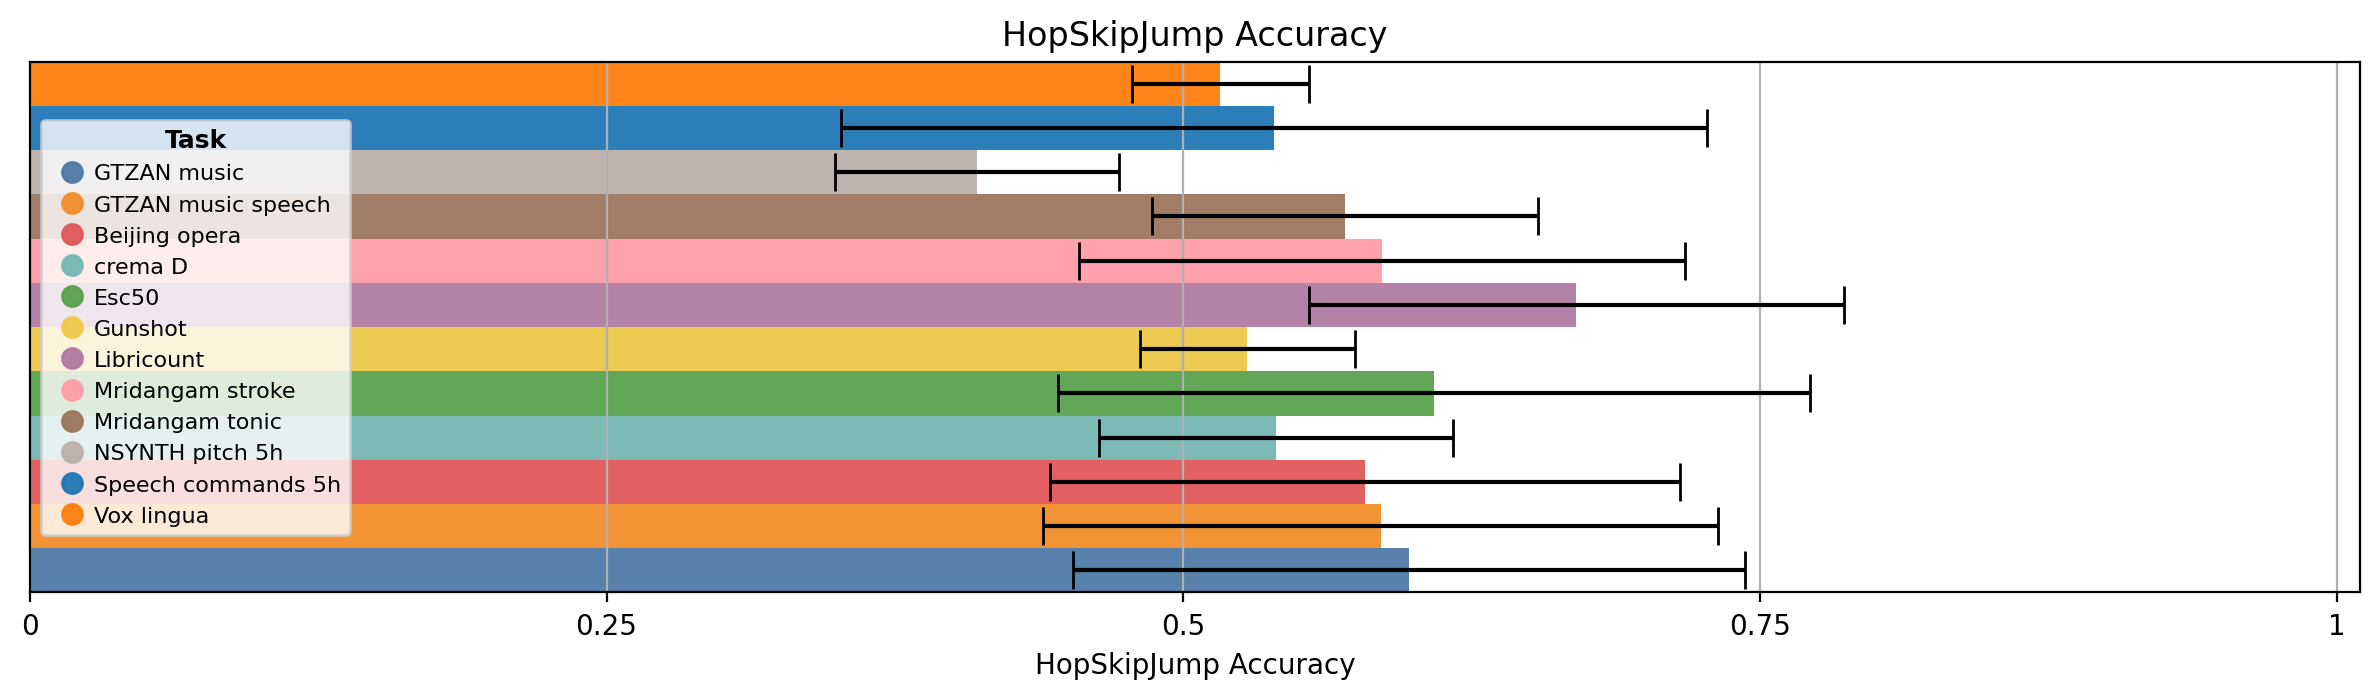

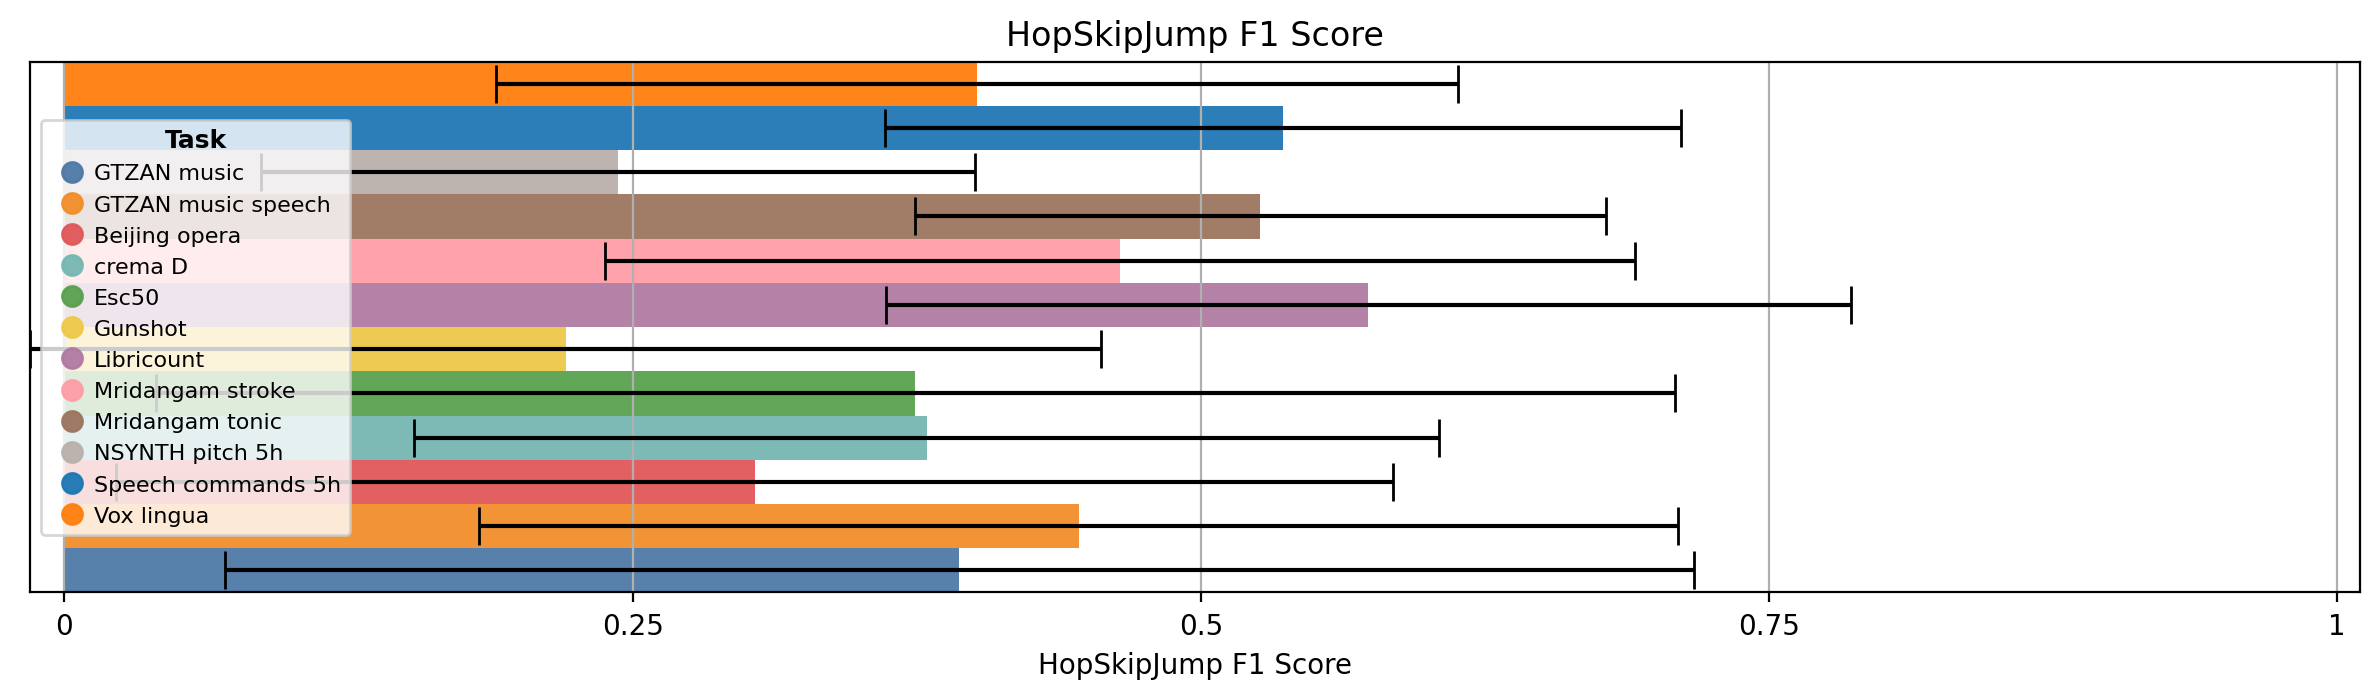

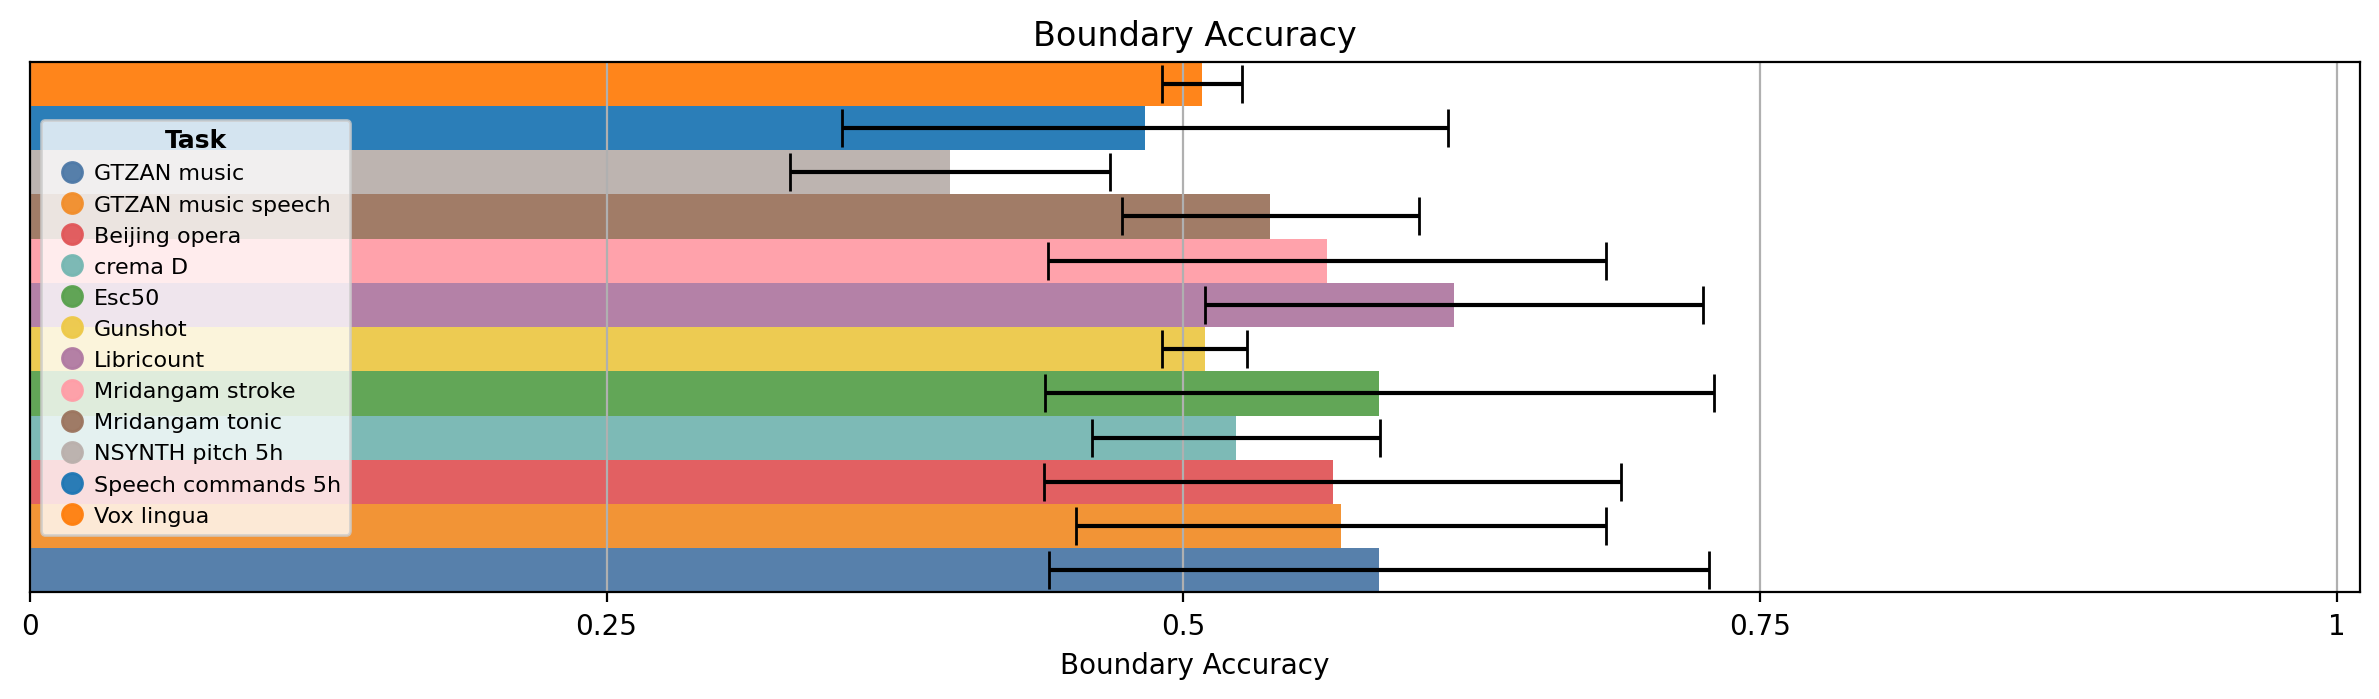

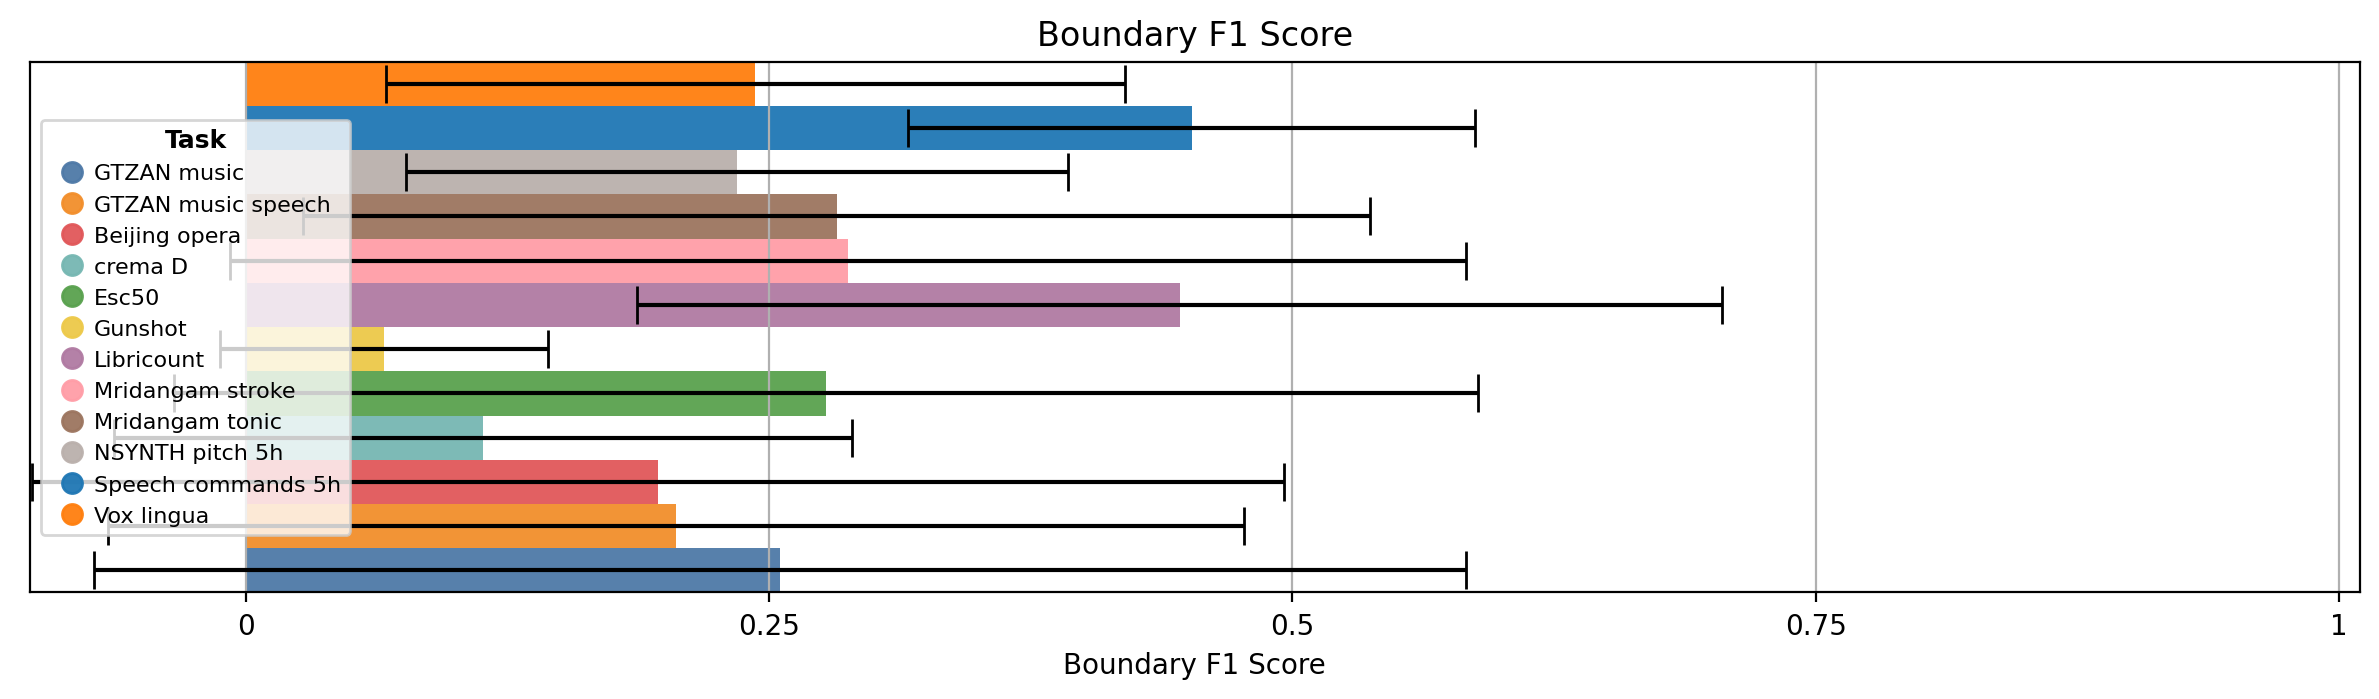

In [12]:
from barplots import barplots

barplots(
    barplot_task_DF,
    groupby=["Task"],
    orientation="horizontal",
    height=12,
    legend_position="center left"
)